# Vehicle detection

## Steps

1. Calibrate camera
1. Extract features
    - Color bins 
    - Color histograms
    - HOG
1. Normalize features (PCA?)
1. Train SVM with features
    - Augmentation (flip images)
1. Use sliding windows to find cars at different scales / positions
1. Use a heatmap to remove false positives.

## Imports and helpers

In [17]:
%matplotlib inline
from itertools import product
import pickle

import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.externals import joblib

from skimage.feature import hog
from skimage.measure import label, regionprops

from moviepy.editor import VideoFileClip
from IPython.display import HTML
from functools import partial

In [2]:
def display_video(video):
    return HTML('<video width="960" height="540" controls src="{}"/>'.format(video))

In [3]:
def plot1(img1, title1=None, filename=None, figsize=(8, 4)):
    plt.figure(figsize=figsize)        
    if title1 is not None:
        plt.title(title1)
    plt.imshow(img1, cmap=plt.cm.Greys_r)
    
    if filename is not None:
        plt.savefig('./output_images/{}'.format(filename))
        
def plot2(img1, img2, title1=None, title2=None, filename=None, figsize=(16, 4)):
    plt.figure(figsize=figsize)
    
    plt.subplot(121)
    if title1 is not None:
        plt.title(title1)
    plt.imshow(img1, cmap=plt.cm.Greys_r)
    
    plt.subplot(122)
    if title2 is not None:
        plt.title(title2) 
    plt.imshow(img2, cmap=plt.cm.Greys_r)
    
    if filename is not None:
        plt.savefig('./output_images/{}'.format(filename))

# Dataset preparation and analysis

In [4]:
def data_look(car_list, notcar_list):
    data_dict = {}
    data_dict["n_cars"] = len(car_list)
    data_dict["n_notcars"] = len(notcar_list)
    img = car_list[0]
    data_dict["image_shape"] = img.shape
    data_dict["data_type"] = img.dtype
    return data_dict

### Udacity dataset 

These example images come from a combination of the GTI vehicle image database, the KITTI vision benchmark suite, and examples extracted from the project video itself.

In [5]:
# !curl https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip > datasets/vehicles.zip
# !curl https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip > datasets/non-vehicles.zip
# %cd datasets
# !unzip vehicles.zip
# !rm -rf __MACOSX
# !unzip non-vehicles.zip
# !rm -rf __MACOSX
# %cd ..

{'n_cars': 8792, 'n_notcars': 8968, 'image_shape': (64, 64, 3), 'data_type': dtype('uint8')}


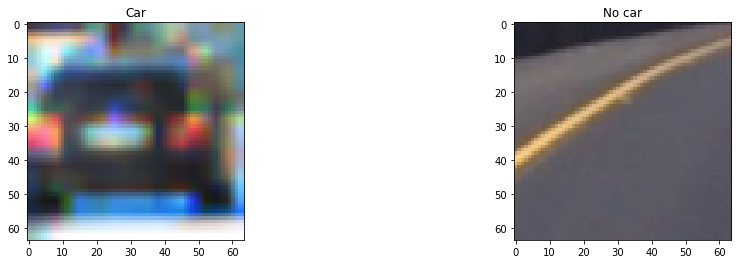

In [6]:
vehicles = [ (plt.imread(f) * 255).astype(np.uint8) for f in glob.glob("./datasets/vehicles/**/*.png") ]
non_vehicles = [ (plt.imread(f) * 255).astype(np.uint8) for f in glob.glob("./datasets/non-vehicles/**/*.png") ]

print(data_look(vehicles, non_vehicles))

# Random sample images
example_vehicles = vehicles[np.random.randint(len(vehicles))]
example_non_vehicles = non_vehicles[np.random.randint(len(non_vehicles))]
plot2(example_vehicles, example_non_vehicles, "Car", "No car", filename="samples.jpg")

## Combine datasets and preprocess them.

In [7]:
# Combine datasets (set y = 1 if is a vehicle; 0 otherwise)
X = np.vstack([vehicles, non_vehicles])
y = np.hstack([np.ones(len(vehicles)), np.zeros(len(non_vehicles))])

# Shuffles and splits the data in a stratified fashion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
print('Shapes: X_train={} X_test={}'.format(X_train.shape, X_test.shape))
print(np.max(X))

Shapes: X_train=(14208, 64, 64, 3) X_test=(3552, 64, 64, 3)
255


## Feature extraction and preprocessing

In [26]:
def bin_spatial(img, size=(32, 32)):
    """ Compute binned color features"""

    features = cv2.resize(img, size).ravel() 
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    """ Compute color histogram features"""
    
    channels_hist = [np.histogram(img[:,:,c], bins=nbins, range=bins_range)[0] for c in range(img.shape[-1])]
    hist_features = np.concatenate(channels_hist)
    return hist_features


def convert_color(image, cspace='RGB'):
    """ Convert image to color space """
    
    mapping = {
        'HSV':  cv2.COLOR_RGB2HSV,
        'LUV':  cv2.COLOR_RGB2LUV,
        'HLS':  cv2.COLOR_RGB2HLS,
        'YUV':  cv2.COLOR_RGB2YUV,
        'YCrCb': cv2.COLOR_RGB2YCrCb,
    }
        
    if cspace != 'RGB':
        return cv2.cvtColor(image, mapping[cspace])
    else: 
        return image


def get_hog_features(img, orient, pixels_per_cell, cells_per_block, transform_sqrt=True, vis=False, feature_vec=True):    
    """ Returns HOG features and visualization """
    
    return hog(img, orientations=orient, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
               cells_per_block=(cells_per_block, cells_per_block), transform_sqrt=transform_sqrt, 
               visualise=vis, feature_vector=feature_vec, block_norm='L1')

def hog_features(img, orient, pixels_per_cell, cells_per_block, transform_sqrt=True, channels=[0]):    
    feats = []
    for channel in channels:
        feats.append(get_hog_features(img[:,:,channel], 
                            orient, pixels_per_cell, cells_per_block))
    return np.ravel(feats)                       

class ColorConverter(BaseEstimator, TransformerMixin):
    """ Feature extraction wrapped in a sklearn transformer. """

    def __init__(self, cspace='RGB'):
        self.cspace=cspace
        
    def fit(self, x, y=None, **fit_params):
        return self
    
    def transform(self, X):
        images = []
        for image in X:
            images.append(convert_color(image, self.cspace))
        return images
            
class SpatialBins(BaseEstimator, TransformerMixin):
    """ Feature extraction wrapped in a sklearn transformer. """

    def __init__(self, spatial_size=(32, 32)):
        self.spatial_size=spatial_size      

    def fit(self, x, y=None, **fit_params):
        return self
    
    def transform(self, X):
        images = []
        for image in X:
            images.append(bin_spatial(image, self.spatial_size))
        return images
    
class ColorHistogram(BaseEstimator, TransformerMixin):
    """ Feature extraction wrapped in a sklearn transformer. """

    def __init__(self, hist_bins=32, hist_range=(0, 256)):
        self.hist_bins=hist_bins
        self.hist_range=hist_range

    def fit(self, x, y=None, **fit_params):
        return self
    
    def transform(self, X):
        images = []
        for image in X:
            images.append(color_hist(image, self.hist_bins, self.hist_range))
        return images

class HOG(BaseEstimator, TransformerMixin):
    """ Feature extraction wrapped in a sklearn transformer. """

    def __init__(self, orient=12, pixels_per_cell=8, cells_per_block=2, transform_sqrt=True, channels=[0]):
        self.orient=orient
        self.pixels_per_cell=pixels_per_cell
        self.cells_per_block=cells_per_block
        self.channels=channels
        self.transform_sqrt=transform_sqrt

    def fit(self, x, y=None, **fit_params):
        return self
    
    def transform(self, X):
        images = []
        for image in X:
            images.append(hog_features(image, 
                           orient=self.orient, 
                           pixels_per_cell=self.pixels_per_cell, 
                           cells_per_block=self.cells_per_block,
                           channels=self.channels,
                           transform_sqrt=self.transform_sqrt))
        return images
    

## Train classifier

### Build pipeline

In [9]:
svc_pipeline = Pipeline([
        ('color', ColorConverter()),
        ('feat', FeatureUnion([
            ('bin_spatial', SpatialBins()),
            ('color_hist', ColorHistogram()),
            ('hog', HOG())
        ])),
        ('scl', StandardScaler()),
#         ('pca', PCA()),
        ('clf', LinearSVC())
    ],
    memory='./param_search_cache/'
)

### Hyperparameter tuning via grid search

In [10]:

param_dist = {
    'color__cspace': ['RGB', 'LUV', 'HLS', 'YUV', 'YCrCb'],
    'feat__bin_spatial__spatial_size': [(32, 32), (16, 16)],
    'feat__color_hist__hist_bins': [32, 16],    
    'feat__hog__channels': [(0,)],
    'feat__hog__orient': [8, 12],
    'feat__hog__pixels_per_cell': [8, 16],
    'feat__hog__cells_per_block': [2, 4],
#     'pca__n_components': [None, .9, .93, .95, .97, .99],
#     'pca__whiten': [ True, False ],
    'clf__C': np.logspace(-4, 2, 7), # [0.0001, ..., 100]
}

param_search = RandomizedSearchCV(
    estimator=svc_pipeline, 
    param_distributions=param_dist,
    scoring='accuracy',
    cv=3,
    n_iter=200,
    n_jobs=12,
    verbose=10
)

In [13]:
# features = extract_features(X_train)
%time param_search.fit(X_train, y_train)
print('Best hyperparameters: ', param_search.best_params_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YUV, clf__C=1.0 
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YUV, clf__C=1.0 
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YUV, clf__C=1.0 
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=HLS, clf__C=1.0 
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__ho

[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  1.2min


[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=HLS, clf__C=1.0, score=0.9575591216216216, total=  51.3s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=0.0001 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=HLS, clf__C=1.0, score=0.9573389651531151, total=  52.7s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=0.0001 
[CV]  feat__hog__pixels_per_cell=16, feat_

[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.4min


[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YCrCb, clf__C=0.1, score=0.9757230314545071, total= 1.1min
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=RGB, clf__C=10.0 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YUV, clf__C=1.0, score=0.9820523648648649, total= 1.2min
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=RGB, clf__C=100.0 
[CV]  feat__hog__pixels_per_cell=8, feat__

[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:  2.5min


[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=0.0001, score=0.9816261879619852, total= 1.0min
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=RGB, clf__C=0.1 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=HLS, clf__C=0.01, score=0.9666314677930307, total= 1.1min
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=HLS, clf__C=0.01 
[CV]  feat__hog__pixels_per_cell=8, feat__

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  3.9min


[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=RGB, clf__C=0.01 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=HLS, clf__C=0.001, score=0.963893581081081, total= 1.1min
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=RGB, clf__C=0.01 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=RGB, clf__C=0.1, score=0.980152027027027, total= 1.2min
[CV] feat__hog__pixels_per_cell=16, feat__ho

[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:  5.2min


[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=0.001, score=0.9816261879619852, total=  47.2s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YCrCb, clf__C=100.0 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=RGB, clf__C=0.01, score=0.978247096092925, total= 1.1min
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YCrCb, clf__C=100.0 
[CV]  feat__hog__pixels_per_cell=16

[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:  6.3min


[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=RGB, clf__C=1.0, score=0.979518581081081, total=  37.8s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YCrCb, clf__C=10.0 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YUV, clf__C=0.1, score=0.9833192567567568, total= 1.3min
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YCrCb, clf__C=10.0 
[CV]  feat__hog__pixels_per_cell=16, feat__

[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:  7.8min


[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=1.0, score=0.9767736486486487, total=  28.7s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YCrCb, clf__C=0.0001 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YCrCb, clf__C=10.0, score=0.9776229681232848, total= 1.1min
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YCrCb, clf__C=0.0001 
[CV]  feat__hog__pixels_per_cell=8, 

[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:  9.2min


[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YCrCb, clf__C=0.0001, score=0.9835304054054054, total=  59.2s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=RGB, clf__C=1.0 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=HLS, clf__C=10.0, score=0.9658011399620012, total= 1.1min
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YUV, clf__C=100.0 
[CV]  feat__hog__pixels_per_cell=8, fea

[Parallel(n_jobs=12)]: Done  89 tasks      | elapsed: 10.6min


[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YUV, clf__C=100.0, score=0.9809926082365364, total=  31.1s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=HLS, clf__C=0.1 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=LUV, clf__C=100.0, score=0.9755067567567568, total= 1.1min
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YUV, clf__C=10.0 
[CV]  feat__hog__pixels_per_cell=16, fea

[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed: 12.3min


[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YUV, clf__C=0.1, score=0.9854307432432432, total= 1.5min
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=1.0 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=RGB, clf__C=10.0, score=0.9681165540540541, total=  24.2s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=RGB, clf__C=100.0 
[CV]  feat__hog__pixels_per_cell=8, feat__ho

[Parallel(n_jobs=12)]: Done 121 tasks      | elapsed: 14.5min


[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=HLS, clf__C=0.001, score=0.9744510135135135, total=  50.8s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=100.0 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=HLS, clf__C=0.001, score=0.978247096092925, total=  52.9s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=100.0 
[CV]  feat__hog__pixels_per_cell=8, fea

[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed: 16.2min


[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=100.0, score=0.9801562170149883, total=  59.9s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=HLS, clf__C=10.0 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=100.0, score=0.979518581081081, total= 1.0min
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=HLS, clf__C=10.0 
[CV]  feat__hog__pixels_per_cell=8, feat__h

[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=RGB, clf__C=0.01 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YCrCb, clf__C=100.0, score=0.984375, total= 1.2min
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=HLS, clf__C=1.0 


[Parallel(n_jobs=12)]: Done 157 tasks      | elapsed: 18.4min


[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YUV, clf__C=0.0001, score=0.9801478352692714, total=  56.0s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=HLS, clf__C=1.0 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YCrCb, clf__C=100.0, score=0.9833157338965153, total= 1.2min
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=HLS, clf__C=1.0 
[CV]  feat__hog__pixels_per_cell=16, fea

[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=0.001 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=LUV, clf__C=1.0, score=0.9719112988384372, total= 1.1min
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=0.001 


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed: 20.4min


[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=LUV, clf__C=1.0, score=0.9757230314545071, total= 1.1min
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=0.001 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=HLS, clf__C=1.0, score=0.9702343255224826, total= 1.6min
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YUV, clf__C=0.001 
[CV]  feat__hog__pixels_per_cell=16, feat_

[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=LUV, clf__C=0.0001 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=LUV, clf__C=1.0, score=0.976557550158395, total=  26.0s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=LUV, clf__C=0.0001 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=0.0001, score=0.9748786151572726, total=  12.5s
[CV] feat__hog__pixels_per_cell=16, 

[Parallel(n_jobs=12)]: Done 197 tasks      | elapsed: 22.2min


[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=0.0001, score=0.9748680042238649, total=  13.1s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=LUV, clf__C=0.0001 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=RGB, clf__C=100.0, score=0.9772007599746675, total=  52.7s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=HLS, clf__C=0.0001 
[CV]  feat__hog__pixels_per_cell

[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=1.0 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=1.0, score=0.9778293918918919, total=  55.4s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=1.0 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YCrCb, clf__C=0.1, score=0.9791006966434452, total=  43.0s
[CV] feat__hog__pixels_per_cell=16, feat__ho

[Parallel(n_jobs=12)]: Done 218 tasks      | elapsed: 24.4min


[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YCrCb, clf__C=0.1, score=0.9799408783783784, total=  43.9s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=10.0 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YCrCb, clf__C=10.0, score=0.9763513513513513, total=  48.7s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=10.0 
[CV]  feat__hog__pixels_per_cell=16, f

[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=LUV, clf__C=0.0001 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=10.0, score=0.9721224920802535, total=  51.5s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=LUV, clf__C=0.0001 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=LUV, clf__C=0.01, score=0.9814228414608402, total= 1.2min
[CV] feat__hog__pixels_per_cell=8, feat__

[Parallel(n_jobs=12)]: Done 241 tasks      | elapsed: 26.8min


[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=LUV, clf__C=0.0001, score=0.9847972972972973, total=  18.4s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YCrCb, clf__C=0.01 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=LUV, clf__C=0.0001, score=0.9839493136219641, total=  19.6s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YCrCb, clf__C=0.01 
[CV]  feat__hog__pixels_per_cell=8

[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=10.0 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YCrCb, clf__C=0.01, score=0.9850084459459459, total=  13.3s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=10.0 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YCrCb, clf__C=0.01, score=0.9835269271383316, total=  13.2s
[CV] feat__hog__pixels_per_cell=8, feat_

[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed: 28.9min


[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=10.0, score=0.9835338822039266, total=  21.8s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=1.0 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YUV, clf__C=100.0, score=0.9797340088663711, total=  31.2s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=1.0 
[CV]  feat__hog__pixels_per_cell=8, feat__h

[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=0.01 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YUV, clf__C=100.0, score=0.9702343255224826, total= 1.0min
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=RGB, clf__C=10.0 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=RGB, clf__C=1.0, score=0.9710787418197171, total=  55.3s
[CV] feat__hog__pixels_per_cell=8, feat__h

[Parallel(n_jobs=12)]: Done 289 tasks      | elapsed: 30.9min


[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YUV, clf__C=100.0, score=0.9689545934530095, total= 1.1min
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YCrCb, clf__C=1.0, score=0.9797297297297297, total=  56.1s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=0.001 
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=0.001 
[CV]  feat__hog__pixels_per_cell=16, fe

[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=0.0001 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=RGB, clf__C=0.0001, score=0.9746568109820486, total= 1.1min
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=0.0001 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=RGB, clf__C=10.0, score=0.9788806758183738, total= 1.1min
[CV] feat__hog__pixels_per_cell=16, f

[Parallel(n_jobs=12)]: Done 314 tasks      | elapsed: 33.4min


[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=0.0001, score=0.978247096092925, total=  12.4s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=HLS, clf__C=0.001 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YCrCb, clf__C=0.01, score=0.9801562170149883, total= 1.3min
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YCrCb, clf__C=0.01 
[CV]  feat__hog__pixels_per_cell=8, f

[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=RGB, clf__C=0.1 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YCrCb, clf__C=0.01, score=0.9814149947201689, total=  37.3s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=RGB, clf__C=0.1 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=1.0, score=0.974234424498416, total=  53.9s
[CV] feat__hog__pixels_per_cell=16, feat__ho

[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed: 36.2min


[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=RGB, clf__C=1.0, score=0.9786694825765575, total= 1.1min
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=HLS, clf__C=0.001 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=HLS, clf__C=100.0, score=0.9655755015839493, total=  26.0s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=0.001 
[CV]  feat__hog__pixels_per_cell=16, 

[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YUV, clf__C=0.001 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=HLS, clf__C=0.001, score=0.9736008447729673, total= 1.2min
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YUV, clf__C=0.001 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=HLS, clf__C=0.001, score=0.972339527027027, total=  22.8s
[CV] feat__hog__pixels_per_cell=8, feat

[Parallel(n_jobs=12)]: Done 368 tasks      | elapsed: 38.4min


[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YUV, clf__C=0.001, score=0.979518581081081, total=  30.1s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=0.001 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=HLS, clf__C=0.01, score=0.9712898458940258, total=  52.6s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=1.0 
[CV]  feat__hog__pixels_per_cell=8, feat__

[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YCrCb, clf__C=10.0 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=RGB, clf__C=0.1, score=0.9731784582893347, total=  33.7s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YCrCb, clf__C=10.0 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=10.0, score=0.9788895925691365, total=  52.9s
[CV] feat__hog__pixels_per_cell=8, feat_

[Parallel(n_jobs=12)]: Done 397 tasks      | elapsed: 41.3min


[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=RGB, clf__C=1.0, score=0.9797297297297297, total=  15.2s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=HLS, clf__C=0.01 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=RGB, clf__C=1.0, score=0.9807814149947202, total=  14.5s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=HLS, clf__C=0.01 
[CV]  feat__hog__pixels_per_cell=16, feat__h

[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=HLS, clf__C=0.001 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=HLS, clf__C=10.0, score=0.9611568503272113, total=  18.1s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=HLS, clf__C=0.001 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=RGB, clf__C=100.0, score=0.9763463569165787, total= 1.1min
[CV] feat__hog__pixels_per_cell=16, 

[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed: 43.7min


[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=LUV, clf__C=10.0, score=0.9761402027027027, total= 1.1min
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YUV, clf__C=0.001 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=LUV, clf__C=10.0, score=0.9797340088663711, total= 1.2min
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YUV, clf__C=0.001 
[CV]  feat__hog__pixels_per_cell=16,

[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=0.1 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=0.001, score=0.9850084459459459, total=  50.0s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=HLS, clf__C=1.0 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=0.001, score=0.9839560903525438, total=  51.2s
[CV] feat__hog__pixels_per_cell=8, feat__

[Parallel(n_jobs=12)]: Done 457 tasks      | elapsed: 47.2min


[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=HLS, clf__C=1.0, score=0.9621964097148892, total= 1.4min
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=0.001 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=HLS, clf__C=1.0, score=0.9672788684821617, total= 1.5min
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=0.001 
[CV]  feat__hog__pixels_per_cell=8, feat__ho

[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=LUV, clf__C=0.0001 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YCrCb, clf__C=0.0001, score=0.9704329461457233, total=  15.9s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=LUV, clf__C=0.0001 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=RGB, clf__C=0.01, score=0.9816300675675675, total=  30.7s
[CV] feat__hog__pixels_per_cell=8, f

[Parallel(n_jobs=12)]: Done 488 tasks      | elapsed: 49.3min


[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=RGB, clf__C=0.001 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=RGB, clf__C=10.0, score=0.9784582893347413, total=  25.7s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=RGB, clf__C=0.001 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=RGB, clf__C=0.0001, score=0.976356343677433, total=  19.3s
[CV] feat__hog__pixels_per_cell=8, fea

[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=HLS, clf__C=0.1, score=0.9613597972972973, total=  19.5s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YCrCb, clf__C=0.001 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=HLS, clf__C=0.1, score=0.9638859556494193, total=  19.7s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YCrCb, clf__C=0.001 
[CV]  feat__hog__pixels_per_cell=8, 

[Parallel(n_jobs=12)]: Done 521 tasks      | elapsed: 51.6min


[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=100.0, score=0.9685454929280135, total=  50.1s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=100.0 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YUV, clf__C=0.1, score=0.9805702217529039, total=  14.6s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YCrCb, clf__C=0.0001 
[CV]  feat__hog__pixels_per_cell=16

[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=RGB, clf__C=10.0 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=RGB, clf__C=0.001, score=0.9780359028511088, total=  13.6s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=RGB, clf__C=10.0 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=RGB, clf__C=0.01, score=0.9753008233058899, total=  21.8s
[CV] feat__hog__pixels_per_cell=16, fea

[Parallel(n_jobs=12)]: Done 554 tasks      | elapsed: 53.7min


[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=10.0, score=0.9797340088663711, total=  19.2s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(32, 32), color__cspace=YUV, clf__C=1.0 
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=8, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=10.0, score=0.9782516891891891, total=  20.8s
[CV] feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=RGB, clf__C=0.0001 
[CV]  feat__hog__pixels_per_cell=8, feat__h

[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=0.1 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=4, feat__color_hist__hist_bins=16, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YCrCb, clf__C=10.0, score=0.9689545934530095, total=  14.9s
[CV] feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=LUV, clf__C=0.1 
[CV]  feat__hog__pixels_per_cell=16, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YCrCb, clf__C=0.1, score=0.9820561536837661, total=  16.4s
[CV]  feat__hog__pixels_per_cell=8, f

[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=HLS, clf__C=0.1, score=0.9674762407602957, total= 1.3min
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YCrCb, clf__C=0.01, score=0.9805784251636056, total=  23.4s
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YCrCb, clf__C=0.01, score=0.9852195945945946, total=  22.5s
[CV]  feat__hog__pixels_per_cell=8, feat__hog__orient=12, feat__hog__channels=(0,), feat__hog__cells_per_block=2, feat__color_hist__hist_bins=32, feat__bin_spatial__spatial_size=(16, 16), color__cspace=YCrCb, clf__C=0

[Parallel(n_jobs=12)]: Done 600 out of 600 | elapsed: 57.4min finished


CPU times: user 3min 38s, sys: 2.2 s, total: 3min 41s
Wall time: 58min 17s
Best hyperparameters:  {'feat__hog__pixels_per_cell': 16, 'feat__hog__orient': 12, 'feat__hog__channels': (0,), 'feat__hog__cells_per_block': 2, 'feat__color_hist__hist_bins': 32, 'feat__bin_spatial__spatial_size': (16, 16), 'color__cspace': 'YUV', 'clf__C': 0.001}


In [15]:
clf = param_search.best_estimator_

%time clf.score(X_test, y_test)

CPU times: user 5.21 s, sys: 23.9 ms, total: 5.24 s
Wall time: 5.36 s


0.99042792792792789

In [16]:
clf.get_params()

{'clf': LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0),
 'clf__C': 0.001,
 'clf__class_weight': None,
 'clf__dual': True,
 'clf__fit_intercept': True,
 'clf__intercept_scaling': 1,
 'clf__loss': 'squared_hinge',
 'clf__max_iter': 1000,
 'clf__multi_class': 'ovr',
 'clf__penalty': 'l2',
 'clf__random_state': None,
 'clf__tol': 0.0001,
 'clf__verbose': 0,
 'color': ColorConverter(cspace='YUV'),
 'color__cspace': 'YUV',
 'feat': FeatureUnion(n_jobs=1,
        transformer_list=[('bin_spatial', SpatialBins(spatial_size=(16, 16))), ('color_hist', ColorHistogram(hist_bins=32, hist_range=(0, 256))), ('hog', HOG(cells_per_block=2, channels=(0,), orient=12, pixels_per_cell=16,
   transform_sqrt=True))],
        transformer_weights=None),
 'feat__bin_spatial': SpatialBins(spatial_size=(16, 16)),
 'feat__bin_spatial__spatial_si

In [23]:
cv = pd.DataFrame(param_search.cv_results_).sort('mean_test_score', ascending=False)
cv[:20]

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__C,param_color__cspace,param_feat__bin_spatial__spatial_size,param_feat__color_hist__hist_bins,param_feat__hog__cells_per_block,param_feat__hog__channels,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
187,5.057217,9.360262,0.987120,0.994897,0.001,YUV,"(16, 16)",32,2,"(0,)",...,0.986489,0.995249,0.986909,0.994932,0.987962,0.994511,0.138312,0.276404,0.000619,0.000302
60,48.629961,11.375536,0.986416,0.998909,0.001,YUV,"(16, 16)",32,2,"(0,)",...,0.985434,0.999261,0.986486,0.999050,0.987328,0.998417,2.338529,0.467697,0.000775,0.000359
143,56.492193,12.114789,0.985431,0.999965,0.001,YCrCb,"(32, 32)",32,2,"(0,)",...,0.982901,1.000000,0.987753,1.000000,0.985639,0.999894,2.598800,0.266246,0.001987,0.000050
68,52.125267,12.142438,0.985290,0.994405,0.0001,LUV,"(32, 32)",32,2,"(0,)",...,0.983323,0.994826,0.986064,0.994827,0.986484,0.993561,2.120892,1.287229,0.001402,0.000597
97,42.999682,7.982685,0.985149,0.999543,0.01,YUV,"(16, 16)",32,2,"(0,)",...,0.983745,0.999472,0.985220,0.999789,0.986484,0.999367,0.915718,0.435835,0.001119,0.000179
118,4.728016,8.439645,0.985008,0.993243,0.001,YUV,"(16, 16)",32,2,"(0,)",...,0.984378,0.992820,0.984375,0.993560,0.986272,0.993350,0.265863,0.271679,0.000894,0.000311
159,7.567326,12.367540,0.984797,0.994616,0.0001,YUV,"(32, 32)",32,2,"(0,)",...,0.983745,0.994721,0.986275,0.994932,0.984372,0.994194,0.282257,0.055852,0.001076,0.000310
147,42.696808,7.816044,0.984727,0.992821,0.001,YUV,"(16, 16)",32,4,"(0,)",...,0.983956,0.992926,0.985008,0.992399,0.985216,0.993138,0.312014,0.189647,0.000552,0.000311
188,22.380169,12.535065,0.984586,1.000000,1,YUV,"(32, 32)",32,2,"(0,)",...,0.983534,1.000000,0.985431,1.000000,0.984794,1.000000,0.251261,0.540918,0.000788,0.000000
34,13.916970,11.723763,0.984516,1.000000,10,YUV,"(32, 32)",32,2,"(0,)",...,0.983534,1.000000,0.985220,1.000000,0.984794,1.000000,1.410912,0.621717,0.000716,0.000000


In [18]:
cv.describe()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,38.786978,9.958370,0.976845,0.997674,100.035000,0.976605,0.997744,0.976914,0.997705,0.977017,0.997573,1.230758,0.460906,0.001496,0.000122
std,23.125819,1.623228,0.005799,0.004879,57.955656,0.005200,0.004738,0.006810,0.004872,0.006033,0.005037,1.421645,0.271420,0.000872,0.000203
min,4.053494,6.979886,0.958685,0.980821,1.000000,0.961157,0.980889,0.956292,0.980574,0.957128,0.980365,0.028149,0.019581,0.000097,0.000000
25%,12.334604,8.475344,0.974205,0.999516,50.750000,0.973559,0.999340,0.974240,0.999578,0.973812,0.999367,0.317331,0.249047,0.000792,0.000000
50%,44.757168,9.845713,0.977865,1.000000,99.000000,0.977201,1.000000,0.978463,1.000000,0.978036,1.000000,0.831876,0.414387,0.001312,0.000000
75%,57.714861,11.516433,0.981014,1.000000,149.500000,0.980790,1.000000,0.981419,1.000000,0.981204,1.000000,1.536375,0.616035,0.002072,0.000179
max,88.001340,13.199131,0.987120,1.000000,199.000000,0.986489,1.000000,0.987753,1.000000,0.987962,1.000000,11.753314,1.287229,0.004204,0.001009


In [ ]:
# pca = clf.steps[2][1]
# print("Number of components:", pca.n_components_)

In [28]:
# Save classifier
# joblib.dump(clf, './SVM-classifier.pkl') 

['./SVM-classifier.pkl']

## Sliding window search

In [27]:
classifier = joblib.load('./SVM-classifier.pkl')
%time print("Accuracy in first 100 images: {}".format(classifier.score(X_test[:100], y_test[:100])))

Accuracy in first 100 images: 0.96
CPU times: user 152 ms, sys: 0 ns, total: 152 ms
Wall time: 151 ms


In [28]:
video = VideoFileClip('./project_video.mp4')

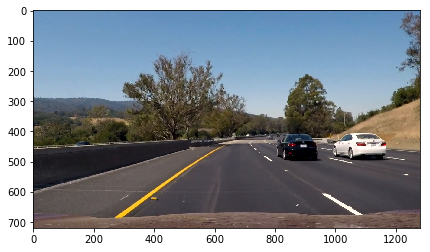

In [29]:
frame = video.get_frame(38)
plot1(video.get_frame(38))

CPU times: user 165 ms, sys: 14 µs, total: 165 ms
Wall time: 165 ms


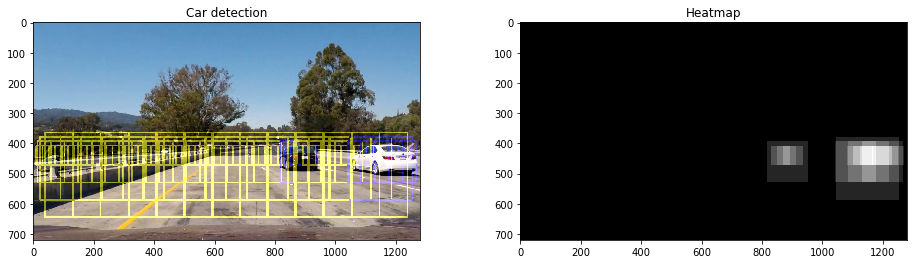

In [32]:
frame = video.get_frame(40)
frame = np.copy(frame)

def find_cars(frame, 
              horizon_y = 420,
              size = 64,
              position_ratio = 5, # position_ratio = (bottom - horizon) / (horizon - top)
              min_window_size = 64,
              max_window_size = 280,
              n_window_sizes = 4,
              step_relative = 3,
              draw_findings = True,
              draw_windows = False
             ):

    step = size // step_relative
    window_sizes = np.linspace(min_window_size, max_window_size, n_window_sizes).astype(np.int)
    tops = horizon_y - (window_sizes) // position_ratio 
    
    windows = []
    positions = []
    for window_size, y1 in zip(window_sizes, tops):
        y2 = y1 + window_size
        scale = window_size / size
        region_width = frame.shape[1] * size // window_size
        region = cv2.resize(frame[y1:y2,...], (region_width, size))
        x_margin = (region_width % step) // 2 
        for x1_r in range(x_margin, x_margin + region_width - size, step):
            x2_r = x1_r + size 
            x1, x2 = int(x1_r * scale), int(x2_r * scale)
            windows += [region[:, x1_r:x2_r]]
            positions += [(x1, y1, x2, y2)]
        
    predictions = classifier.predict(windows)
    
    copy = None
    heatmap = np.zeros(frame.shape[:-1])
    
    if draw_windows or draw_findings:
        copy = np.zeros_like(frame)
        
    for pred, (x1, y1, x2, y2) in zip(predictions, positions):
        if draw_windows:
            cv2.rectangle(copy, (x1,y1), (x2,y2), (255,255,0), 3)
        if pred == 1:
            heatmap[y1:y2, x1:x2] += 1 
            if draw_findings:
                cv2.rectangle(copy, (x1,y1), (x2,y2), (0,0,255), 3)
            
    return heatmap, copy

%time heatmap, img = find_cars(frame, draw_findings=True, draw_windows=True)
img = cv2.addWeighted(frame, 1, img, 0.5, 0)
plot2(img, heatmap, 'Car detection', 'Heatmap', filename='windows_2.jpg')

## Undistort camera 

In order to do so we use the calibration params that we calculated in the previous project.

In [21]:
with open('./calibration.pkl', 'rb') as f:
    calibration = pickle.load(f)

def undistort(objpoints, imgpoints, shape=(720, 1280)):
    retval, cameraMatrix, distCoeffs, rvecs, tvecs = \
        cv2.calibrateCamera(objpoints, imgpoints, tuple(reversed(shape)), None, None)
    def apply(x):
        return cv2.undistort(x, cameraMatrix, distCoeffs) 
    return apply

In [45]:
def process_lines(heatmap_smooth=0.92, heatmap_threshold=12, max_heatmap=15, area_threshold=64*64, use_cache=True, cache=None):
    heatmap = None
    current = 0
    
    undist = undistort(calibration['objpoints'], calibration['imgpoints'])
    
    def apply(frame):
        nonlocal heatmap, current, cache
            
        frame = undist(frame)
#         img = pipeline(frame).astype(np.uint8)

        if heatmap is None:
            heatmap = np.zeros(frame.shape[:-1])
            
        
        if not use_cache:            
            h, _ = find_cars(frame, draw_findings=False)
            if cache is not None:
                cache += [h]
        else:
            h = cache[current]
            current += 1
        
        
        heatmap = heatmap * heatmap_smooth + h
        heatmap[heatmap > max_heatmap] = max_heatmap
        
        regions = np.zeros_like(heatmap)
        regions[heatmap >= heatmap_threshold] = 1
        labels = label(regions)
        
        for p in regionprops(labels):
            y1, x1, y2, x2 = p.bbox
            area = p.area
            if area >= area_threshold:
                cv2.rectangle(frame, (x1,y1), (x2,y2), (127,127,255), 3)
            
#         frame = cv2.resize(frame, (0,0), fx=0.25, fy=0.25)
        return frame

    return apply


video = VideoFileClip("./project_video.mp4")
# video = VideoFileClip("../CarND-Advanced-Lane-Lines/project-video-result.mp4")
# result = video.fl_image(process_lines())
# cache = []
result = video.fl_image(process_lines(use_cache=True, cache=cache))
_ = result.write_videofile("./project-video-result_2.mp4", audio=False)

[MoviePy] >>>> Building video ./project-video-result_2.mp4
[MoviePy] Writing video ./project-video-result_2.mp4


100%|█████████▉| 1260/1261 [00:50<00:00, 25.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project-video-result_2.mp4 



In [44]:
display_video('./project-video-result.mp4')

In [46]:
display_video('./project-video-result_2.mp4')

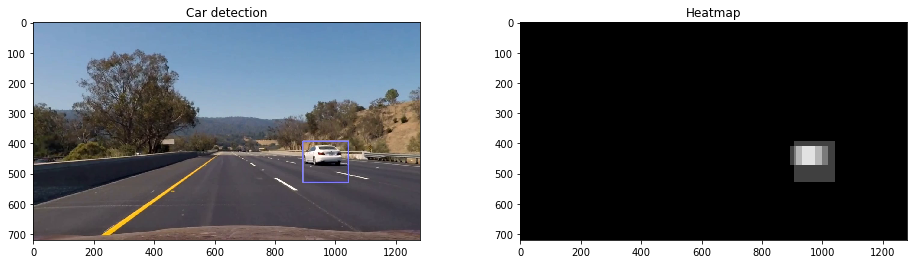

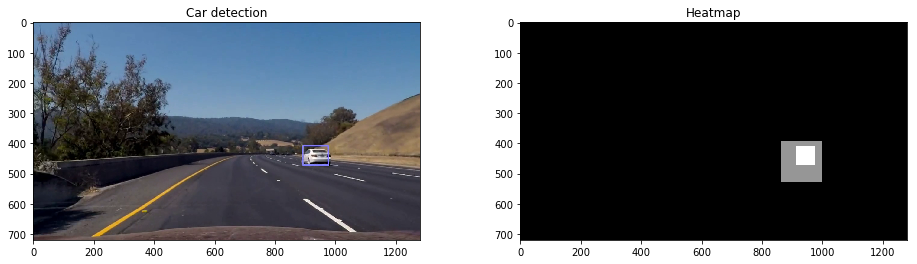

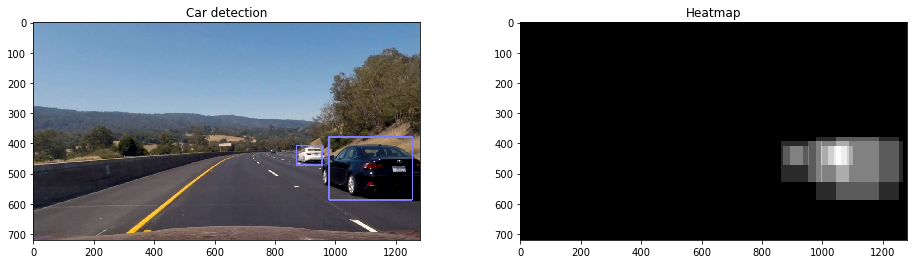

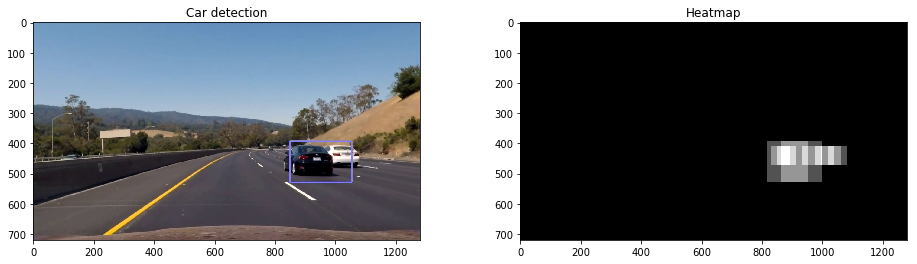

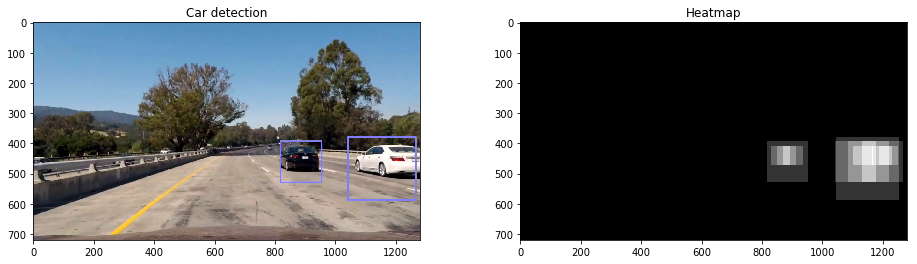

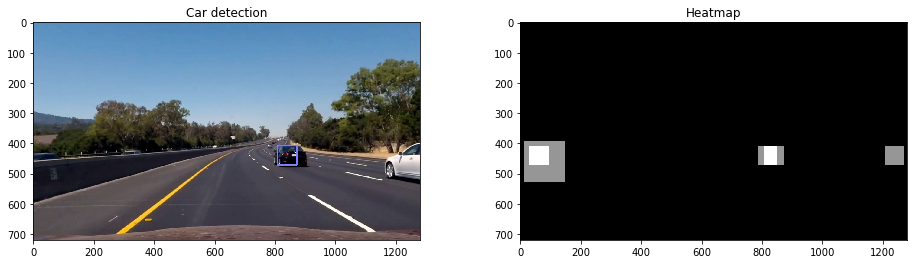

In [59]:
def plot_hm(video, frame):
    img = video.get_frame(frame)
    hm = cache[int(video.fps * frame)]
    plot2(img, hm, 'Car detection', 'Heatmap', filename='frame_{}.jpg'.format(frame))

video = VideoFileClip("./project-video-result_2.mp4")
plot_hm(video, 20)
plot_hm(video, 25)
plot_hm(video, 30)
plot_hm(video, 35)
plot_hm(video, 40)
plot_hm(video, 45)

